<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-functions-&amp;-init-parameters" data-toc-modified-id="Define-functions-&amp;-init-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define functions &amp; init parameters</a></span></li><li><span><a href="#Simulate-BM32-Laue-patterns" data-toc-modified-id="Simulate-BM32-Laue-patterns-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate BM32 Laue patterns</a></span></li><li><span><a href="#34ID" data-toc-modified-id="34ID-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>34ID</a></span></li><li><span><a href="#Play" data-toc-modified-id="Play-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Play</a></span></li></ul></div>

In [1]:
LaueToolsCode_Folder = '/data/id01/inhouse/edo/lauetools_Rev2295_30March18/'
import sys
sys.path.append(LaueToolsCode_Folder)

In [2]:
import time, copy, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np    
import pickle
import transforms3d as tfs

import readwriteASCII as RWASCII   # read and write ASCII file  (IO) 
import readmccd as RMCCD       # read CCD and detector binary file, PeakSearch methods
import laue6
import dict_LaueTools as dc
import CrystalParameters as CP
import dict_LaueTools as DictLT

from generaltools import rotate_around_u, matRot, getRotationAngleFrom2Matrices
from find2thetachi import calc_uflab

from matplotlib.colors import LogNorm
from ipywidgets import interact
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.linalg import norm

%matplotlib inline
# %config InlineBackend.figure_format='retina'

LaueToolsProjectFolder /data/id01/inhouse/edo/lauetools_Rev2295_30March18
Missing library libtiff, Please install: pylibtiff if you need open some tiff images
Cython compiled module 'gaussian2D' for fast computation is not installed!
Cython compiled module for fast computation of Laue spots is not installed!


/usr/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define functions & init parameters

In [4]:
def printround(x, dec=2):
    print(np.round(x, decimals=dec))

def Rz(angle):
    return tfs.euler.euler2mat(0,0,np.deg2rad(angle))

def Ry(angle):
    return tfs.euler.euler2mat(0,np.deg2rad(angle),0)

def Rx(angle):
    return tfs.euler.euler2mat(np.deg2rad(angle),0,0)

def angbetween(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    ang = np.degrees(np.arccos(np.dot(v1, v2)/(norm(v1)*norm(v2))))

    return ang

def plot_simul(peak_x, peak_y, img_num):
    
    y, x = peak_y, peak_x

    plt.figure(figsize=(7,7), dpi=200)
    plt.imshow(candidates[img_num], vmin=0, vmax=120, cmap='gray_r')
    plt.scatter(x, y, s=50, facecolors='none', edgecolors='blue', linewidths=0.3)
    for i in range(posx.size):
        if np.all(abs(miller[i]) <= 4):
            index = miller[i]
            en = np.round(nrj[i], decimals=2)
        else:
            index = ''
            en = ''
        plt.text(x[i]+35, y[i], str(index), color='red', fontsize=9)
        plt.text(x[i]+35, y[i]+50, str(en), color='blue', fontsize=7)
        
def init_u32_111():
    # spits out the 111 U matrix of C5 corrected for the stage rotation in Bm32. This means 
    # this U matrix will rotate the 111 OOP.
    u32_111 = np.array([[-0.907114925923025,  0.189219271479824, -0.375950087633018],
                        [-0.42080574824087 , -0.390639680933938,  0.818732659867284],
                        [0.008058961711265,  0.900886608458518,  0.433979647969956]])
        
    return u32_111

def init_u34_111(u=True):
    # Spits out the 111 U matrix in 34ID. This matrix will rotate the 111 OOP.

    # initial UB from spec, 111 OOP
    ub_s1 = np.array([[-0.87182, -0.88931,-0.90590],
                       [-0.59836, 1.25710, -0.65823],
                       [1.11960, -0.02065, -1.05720]]).copy()

    # calculate the U matrix by dividing by a*
    u_s1 = np.dot(np.eye(3)*(4.08/(2*np.pi)), ub_s1)
    
    if u:
        return u_s1
    elif not u:
        return ub_s1
    
def u32to34(u_matrix):
#     u34 = np.dot(Ry(90).T,
#             np.dot(Rz(120.44432770470202),
#                 np.dot(Ry(40), u_matrix)))
    u34 = np.dot(Rx(90),
            np.dot(Rx(90).T,
                np.dot(Ry(90), 
                       np.dot(Ry(40), u_matrix))))

    return u34

In [5]:
# refined detector parameters for simulation
detector_params = [76.968, 1029.5, 1056.92, 0.454, 0.234] # distance, xcen, ycen, xbet, xgam
pixelsize = 0.0734
dim = (2018, 2016)
detectordiameter = 180#148.1212
emin = 5
emax = 25

In [6]:
# tif files img directory
imgdir = '/data/id01/inhouse/edo/20180515_HC3015_BM32/SiAu_C4/'

# load tif images
img_list = [im for im in os.listdir(imgdir) if 'tif' in im]
img_list.sort()
first_img = RMCCD.readCCDimage(img_list[0], dirname=imgdir, CCDLabel='sCMOS')
imin, imax = first_img[0].min(), first_img[0].max()

# load candidate img dict
candidate_img_numbers = [53, 249, 864, 1010, 1108, 1244, 2953, 2420, 2639, 2831, 3161, 3039, 2831]
sub_img_numbers =       (56, 200, 820, 1016, 1016, 1016, 2947, 2415, 2415, 2825, 2825, 2825, 2825)

candidates = {}

for img_num, sub_num in zip(candidate_img_numbers, sub_img_numbers):
    sub_img, img_size, det_type = RMCCD.readCCDimage(img_list[sub_num], dirname=imgdir, CCDLabel='sCMOS')
    sub_img = sub_img.astype('int16')
    img, img_size, det_type = RMCCD.readCCDimage(img_list[img_num], dirname=imgdir, CCDLabel='sCMOS')
    img = img.astype('int16')
    img -= sub_img
    img[img<0] = 0
    candidates[img_num] = img

## Simulate BM32 Laue patterns

In [7]:
u32_111 = init_u32_111()

# rotate reflection onto bm32 frame
v_110 = np.dot(u32_111, np.array([0,1,1]))

# create rotation matrix from such vector
R = tfs.axangles.axangle2mat(v_110, np.radians(-72))

# rotate bm32 u matrix around such vector
ubnew = u32_111
ubnew = np.dot(R, ubnew) # 72
# ubnew = np.dot(R, ubnew) # 144
# ubnew = np.dot(R, ubnew) # 216
# ubnew = np.dot(R, ubnew) # 288
# ubnew = np.dot(R, ubnew) # 360 back to the start

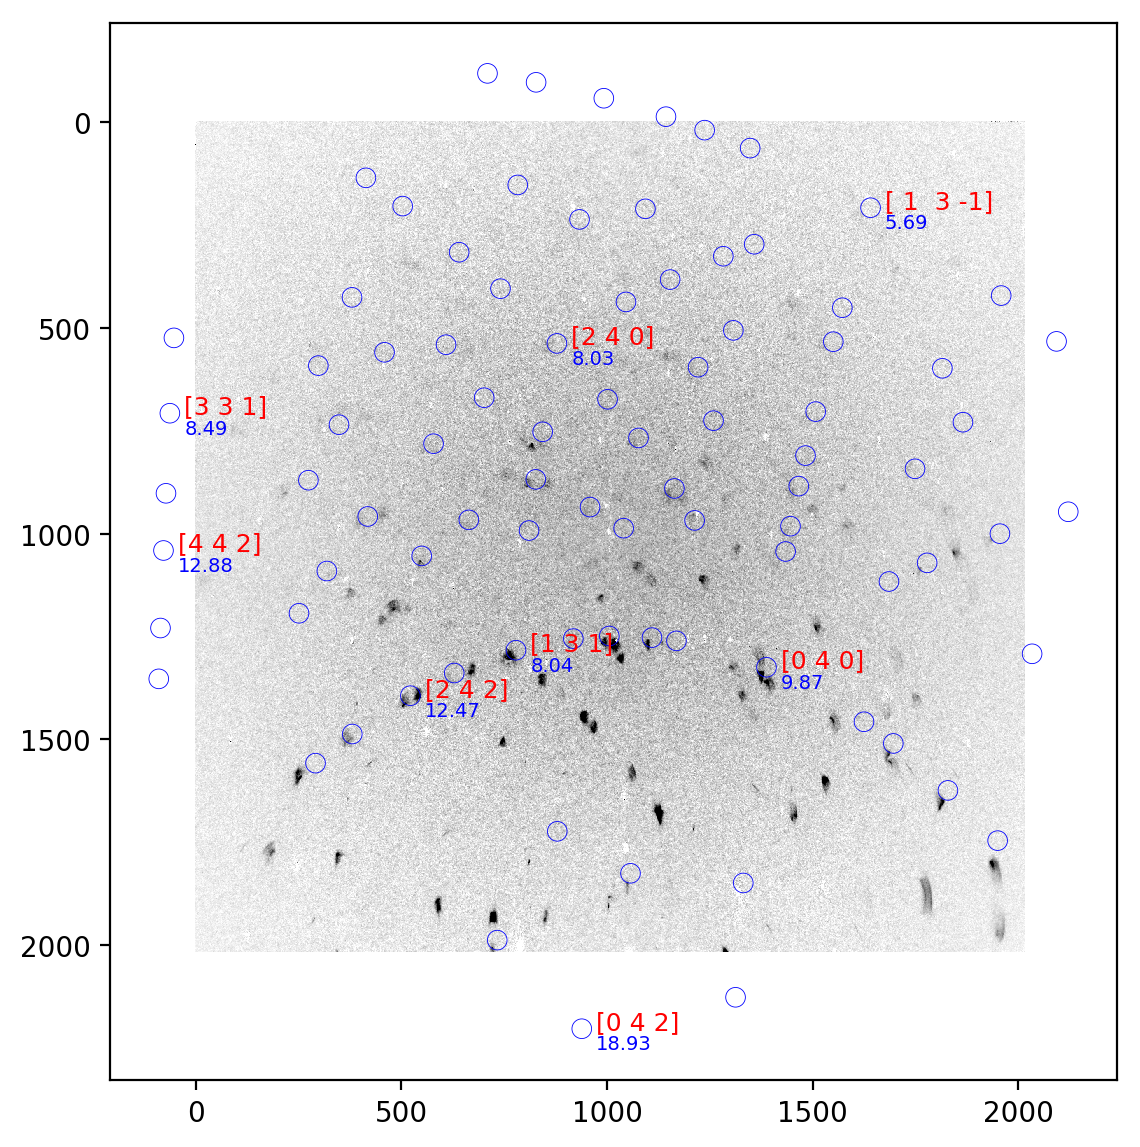

In [8]:
# make Au grain - returns [B, exctinctions, U, material_key]
grain = CP.Prepare_Grain('Au', OrientMatrix=ubnew) 

# simulate Laue pattern from grain
tth, chi, miller, posx, posy, nrj = laue6.SimulateLaue(grain, emin, emax, detector_params, 
                                                       pixelsize=pixelsize, dim=dim, 
                                                      detectordiameter=detectordiameter,
                                                      removeharmonics=1)
# plot the simulation
plot_simul(posx, posy, 249)

## 34ID

In [9]:
## NOTE - THIS IS NOT RIGHT - THE TRANSFORMATION IS NOT RIGHT
# express rotated BM32 U matrix in 34ID coordinates
unew34 = u32to34(init_u32_111())

# make into a UB matrix multiplying by a*
ubnew34 = np.dot(np.eye(3)*((2*np.pi)/4.08), unew34)

# print result 
for line in ubnew34:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

0.907451744966 0.875474673445 0.884117716704
-0.648039336893 -0.601583701874 1.26084534779
1.06215114344 -1.11500223913 0.0139180792767


In [10]:
# original 34 id matrix OOP
ub_s1 = init_u34_111(u=False)

ax011 = np.dot(ub_s1, np.array([0,1,1]))
ubrot = tfs.axangles.axangle2mat(ax011, np.radians(-72))
ubnew34 = np.dot(ubrot, ub_s1)

# print result 
for line in ubnew34:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

-0.280565487437 -1.48133919476 -0.313870805236
-1.47296215037 0.192974337517 0.405895662483
-0.351104646556 0.374157992987 -1.45200799299


## Play

In [ ]:
ub_s1 = np.array([[-0.87182, -0.88931,-0.90590],
                   [-0.59836, 1.25710, -0.65823],
                   [1.11960, -0.02065, -1.05720]]).T.copy()#.T.copy()

ub_m72_011 = np.array([[-0.26734, -1.49208, -0.27174],
          [1.04278, -0.38119, 1.06719],
          [-1.10124, 0.00126, 1.07650]]).T.copy()

ub_m144_011 = np.array([[-0.89522, -0.87498, -0.89700],
                       [-0.68496, -0.58142, 1.25075],
                       [-1.04929, 1.12604, -0.05119]])#.T.copy()

ub_m216_011 = np.array([[-0.29711, -0.27637, -1.48558],
                        [-1.44308, 0.50092, 0.19543],
                        [0.44815, 1.42979, -0.35562]]).T.copy()


ub_m288_011 = np.array([[0.75327, -0.48946, -1.25085],
                         [0.22900, 1.36632, -0.67255],
                          [1.32354, 0.51497, 0.59553]]).T.copy()
##

ub_s2 = np.array([[-1.487082843194333, -0.274047156805667, -0.291702478291803],
                  [-0.399972325281125,  1.058712325281125,  1.044386988753434],
                  [ 0.014687358042543,  1.084262641957457, -1.093507597038519]]).T.copy()

ub_s3 = np.array([[-0.268644977548564, -1.492485022451436, -0.268172098823906],
                  [0.485344598471726,  0.173395401528274, -1.451196403845826],
                  [1.436620847256593, -0.337670847256593,  0.440120558230723]]).T.copy()

In [81]:
# to BM32 flat
np.dot(Ry(40), np.dot(init_u32_111(), np.array([-1,1,0])))

array([ 1.413739268636482,  0.030166067306932, -0.020764380712461])

In [82]:
# to 34ID
np.dot(init_u34_111(), np.array([-1,0,1]))

array([-0.022129921879133, -0.03887671428708 , -1.413509798899546])

In [95]:
reflorigin = np.eye(3)
reflorigin[0,0] = -1
reflorigin[1,1] = -1